## Enrichment of trans-eQTLs in the DHS regions

We look at the predicted trans-eQTLs and find the number of SNPs which are in the DHS regions. Had we selected SNPs randomly, how many would have been in the DHS regions?

Enrichment = $\frac{\text{Fraction of trans-eQTLs in DHS region}}{\text{fraction of randomly selected SNPs in DHS region}}$

In [11]:
resdir = "/usr/users/sbanerj/trans_eqtl_results/gtex_v8"
#tissuelist = ["ms", "at"]
tissuelist = ["ms", "at", "thy", "nt", "snse", "lu", "av", "br", "hlv", "aa", "haa", "colt", "as", "sse"]
tissue_file = "../plots/tissues.txt"
tejaas_preproc = "raw_std"
tejaas_method_variant = "permnull_sb0.1_knn"
rrfile = "rr.txt"
chrmlist = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
pcutoff = 5e-8

In [3]:
dhs_file = "../external/multi-tissue.master.ntypes.simple.hg38_hglft_genome_620db_fada10_clean.bed"
json_file = "../external/gtex_metadata.json"

In [33]:
import numpy as np
import collections
import os
import sys
import json

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
from utils import mpl_stylesheet
from utils import utils
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 22, colors = 'banskt', dpi = 300)

log10cutoff = -np.log10(pcutoff)

In [18]:
tshorts, tfulls = utils.read_tissues(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
for tshort, tfull in zip(tshorts, tfulls):
    if tshort in tissuelist:
        tissue_names[tshort] = tfull
        tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]

In [5]:
def read_tejaas(filename):
    rsidlist = list()
    bplist   = list()
    pvallist = list()
    with open(filename, 'r') as instream:
        next(instream)
        for line in instream:
            linesplit = line.strip().split()
            rsid = linesplit[0]
            bppos = int(linesplit[1])
            pval = float(linesplit[5])
            rsidlist.append(rsid)
            bplist.append(bppos)
            pvallist.append(pval)
    return rsidlist, pvallist, bplist

def read_tejaas_all_chrom(filefmt, chrmlist):
    gwrsids = list()
    gwpvals = list()
    gwnsnps = dict()
    gwbppos = dict()
    
    for chrm in chrmlist:
        filepath = filefmt.format(chrm)
        rsids, pvals, bplist = read_tejaas(filepath)
        gwrsids += rsids
        gwpvals += pvals
        gwnsnps[chrm] = len(rsids)
        gwbppos[chrm] = np.array(bplist)
        
    gwpvals = np.array(gwpvals)
    
    ## Sanity check of p-value
    # Are there any nan p-values?
    nan_mask = np.isnan(gwpvals)
    if np.any(nan_mask):
        print(f'SNPs with nan p-value: {np.sum(nan_mask)}')
        gwpvals[np.where(nan_mask)[0]] = 1.0 ## just ignore this SNP
        
    # Are there any zero p-values
    zero_mask = gwpvals == 0
    if np.any(zero_mask):
        print(f'SNPs with zero p-value: {np.sum(zero_mask)}')
        gwpvals[np.where(zero_mask)[0]] = np.min(gwpvals[~zero_mask])    
    
    #pmax  = np.max(gwpvals[np.where(gwpvals > 0)])
    #nonzero_pvals = gwpvals.copy()
    #nonzero_pvals[np.where(gwpvals == 0)] = pmax
    
    return gwrsids, gwnsnps, gwbppos, gwpvals

In [6]:
def find_annotated(res_dict, dhs_file):
    dhs = open(dhs_file)
    line = dhs.readline()
    prev_chrm = 0
    nannot = 0

    while line:
        arr = line.rstrip().split()
        chrm = int(arr[0][3:])
        start = int(arr[1])
        end = int(arr[2])
        if chrm != prev_chrm:
            remaining = res_dict[chrm]
            checked = 0
        if len(remaining) == 0:
            ## No more SNPs in this chromosome, just continue reading the DHS file
            line = dhs.readline()
        else:
            for pos in remaining:
                if pos < start:
                    checked += 1
                    remaining = res_dict[chrm][checked:]
                    continue # go to next SNP
                elif pos > end:
                    line = dhs.readline()
                    break # go to next DHS line, keep checking the remaining results
                else:
                    # this is an annotated SNP
                    checked += 1
                    remaining = res_dict[chrm][checked:]
                    nannot += 1
                    continue # go to next SNP
        prev_chrm = chrm
    dhs.close()
    return nannot

#### Read any one tissue to get the list of rsids

In [7]:
filefmt = f'{resdir}/{tissuelist[0]}/tejaas/{tejaas_preproc}/{tejaas_method_variant}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, _, _, _ = read_tejaas_all_chrom(filefmt, chrmlist)

SNPs with zero p-value: 30


#### Randomly select 1000 SNPs and see how many are annotated.

Repeat 20 times

In [ ]:
def random_annotated(Nrand, snppos, chrmlist):
    mindist_rand = list()
    ratios = np.random.rand(len(chrmlist))
    ndraws = [int(x) for x in np.around(Nrand * ratios / np.sum(ratios))]
    for i, chrm in enumerate(chrmlist):
        N = ndraws[i]
        firstpos = snppos[chrm][0]
        lastpos  = snppos[chrm][1]
        rands = firstpos + np.random.rand(N) * (lastpos - firstpos)
        selects = np.sort([int(x) for x in rands])
        tfchrmlist = [x for x in tflist if x.chrom == chrm]
        tfstarts = [x.start for x in tflist if x.chrom == chrm]
        tfends = [x.end for x in tflist if x.chrom == chrm]
        for spos in selects:
            xmin = find_minimum_distance(spos, tfstarts, tfends)
            mindist_rand.append(xmin / 1e6)
    mindist_rand = np.array(mindist_rand)
    return mindist_rand

In [8]:
def annotated_random(gwrsids, nchoose, dhs_file):
    chooseidx = np.sort(np.random.choice(len(gwrsids), nchoose, replace = False))
    res_dict = dict()
    for chrm in range(1, 23):
        res_dict[chrm] = list()
    for idx in chooseidx:
        var_id = gwrsids[idx]
        info = var_id.split('_')
        chrm = int(info[0][3:])
        bppos = int(info[1])
        res_dict[chrm].append(bppos)
    nannot = find_annotated(res_dict, dhs_file)
    return nannot

In [9]:
nchoose = 1000
niter = 20
nannot_rand = list()

for k in range(niter):
    nannot_k = annotated_random(gwrsids, nchoose, dhs_file)
    print(f'Iteration {k}: {nannot_k}')
    nannot_rand.append(nannot_k)
    
dhs_frac_rand = np.mean(nannot_rand) / nchoose
print (f'Fraction of annotated SNPs: {dhs_frac_rand:7.4f}')

Iteration 0: 172
Iteration 1: 171
Iteration 2: 151
Iteration 3: 183
Iteration 4: 147
Iteration 5: 163
Iteration 6: 160
Iteration 7: 176
Iteration 8: 194
Iteration 9: 168
Iteration 10: 156
Iteration 11: 169
Iteration 12: 169
Iteration 13: 174
Iteration 14: 164
Iteration 15: 176
Iteration 16: 173
Iteration 17: 166
Iteration 18: 150
Iteration 19: 164
Fraction of annotated SNPs:  0.1673


#### Trans-eQTLs discovered by TEJAAS

In [13]:
transeqtls = dict()

for tissue in tissuelist:
    filefmt = f'{resdir}/{tissue}/tejaas/{tejaas_preproc}/{tejaas_method_variant}/chr' + "{:d}" + f'/{rrfile}'
    gwrsids, gwnsnps, gwbppos, gwpvals = read_tejaas_all_chrom(filefmt, chrmlist)   
    gwlog10pvals = -np.log10(gwpvals)
    nchoose = np.where(gwlog10pvals >= log10cutoff)[0]
    transeqtls[tissue] = [gwrsids[i] for i in nchoose]
    print(f'{tissue}: {len(transeqtls[tissue])} trans-eQTLs')

SNPs with zero p-value: 30
ms: 3087 trans-eQTLs
at: 788 trans-eQTLs
SNPs with zero p-value: 25
thy: 2294 trans-eQTLs
SNPs with zero p-value: 2
nt: 1576 trans-eQTLs
SNPs with zero p-value: 10
snse: 1173 trans-eQTLs
SNPs with zero p-value: 6
lu: 955 trans-eQTLs
SNPs with nan p-value: 1
av: 435 trans-eQTLs
SNPs with nan p-value: 5
br: 610 trans-eQTLs
SNPs with nan p-value: 8
hlv: 280 trans-eQTLs
SNPs with nan p-value: 33
SNPs with zero p-value: 89
aa: 3289 trans-eQTLs
SNPs with nan p-value: 15
haa: 0 trans-eQTLs
SNPs with nan p-value: 11
SNPs with zero p-value: 6
colt: 1888 trans-eQTLs
SNPs with zero p-value: 11
as: 1329 trans-eQTLs
SNPs with zero p-value: 13
sse: 315 trans-eQTLs


In [25]:
dhs_annotated['haa']

0

In [28]:
dhs_annotated = dict()
enrichment = dict()

for tissue in tissuelist:
    dhs_annotated[tissue] = 0
    if len(transeqtls[tissue]) > 0:
        res_dict = dict()
        for chrm in range(1, 23):
            res_dict[chrm] = list()
        for var_id in transeqtls[tissue]:
            info = var_id.split('_')
            chrm = int(info[0][3:])
            bppos = int(info[1])
            res_dict[chrm].append(bppos)
        dhs_annotated[tissue] = find_annotated(res_dict, dhs_file)
        enrichment[tissue] = float(dhs_annotated[tissue]) / len(transeqtls[tissue]) / dhs_frac_rand
        print (f'{tissue}: {dhs_annotated[tissue]} annotated out of {len(transeqtls[tissue])}. Enrichment = {enrichment[tissue]}')

ms: 620 annotated out of 3087. Enrichment = 1.2004915819400368
at: 169 annotated out of 788. Enrichment = 1.2819306938203354
thy: 398 annotated out of 2294. Enrichment = 1.037035724577903
nt: 320 annotated out of 1576. Enrichment = 1.213662195332862
snse: 222 annotated out of 1173. Enrichment = 1.131251117874838
lu: 196 annotated out of 955. Enrichment = 1.2267519551359285
av: 105 annotated out of 435. Enrichment = 1.4427932477276006
br: 123 annotated out of 610. Enrichment = 1.2052560924225646
hlv: 32 annotated out of 280. Enrichment = 0.6831184356587823
aa: 627 annotated out of 3289. Enrichment = 1.139482674865611
colt: 372 annotated out of 1888. Enrichment = 1.1777280233418095
as: 255 annotated out of 1329. Enrichment = 1.1468833781517367
sse: 84 annotated out of 315. Enrichment = 1.5939430165371586


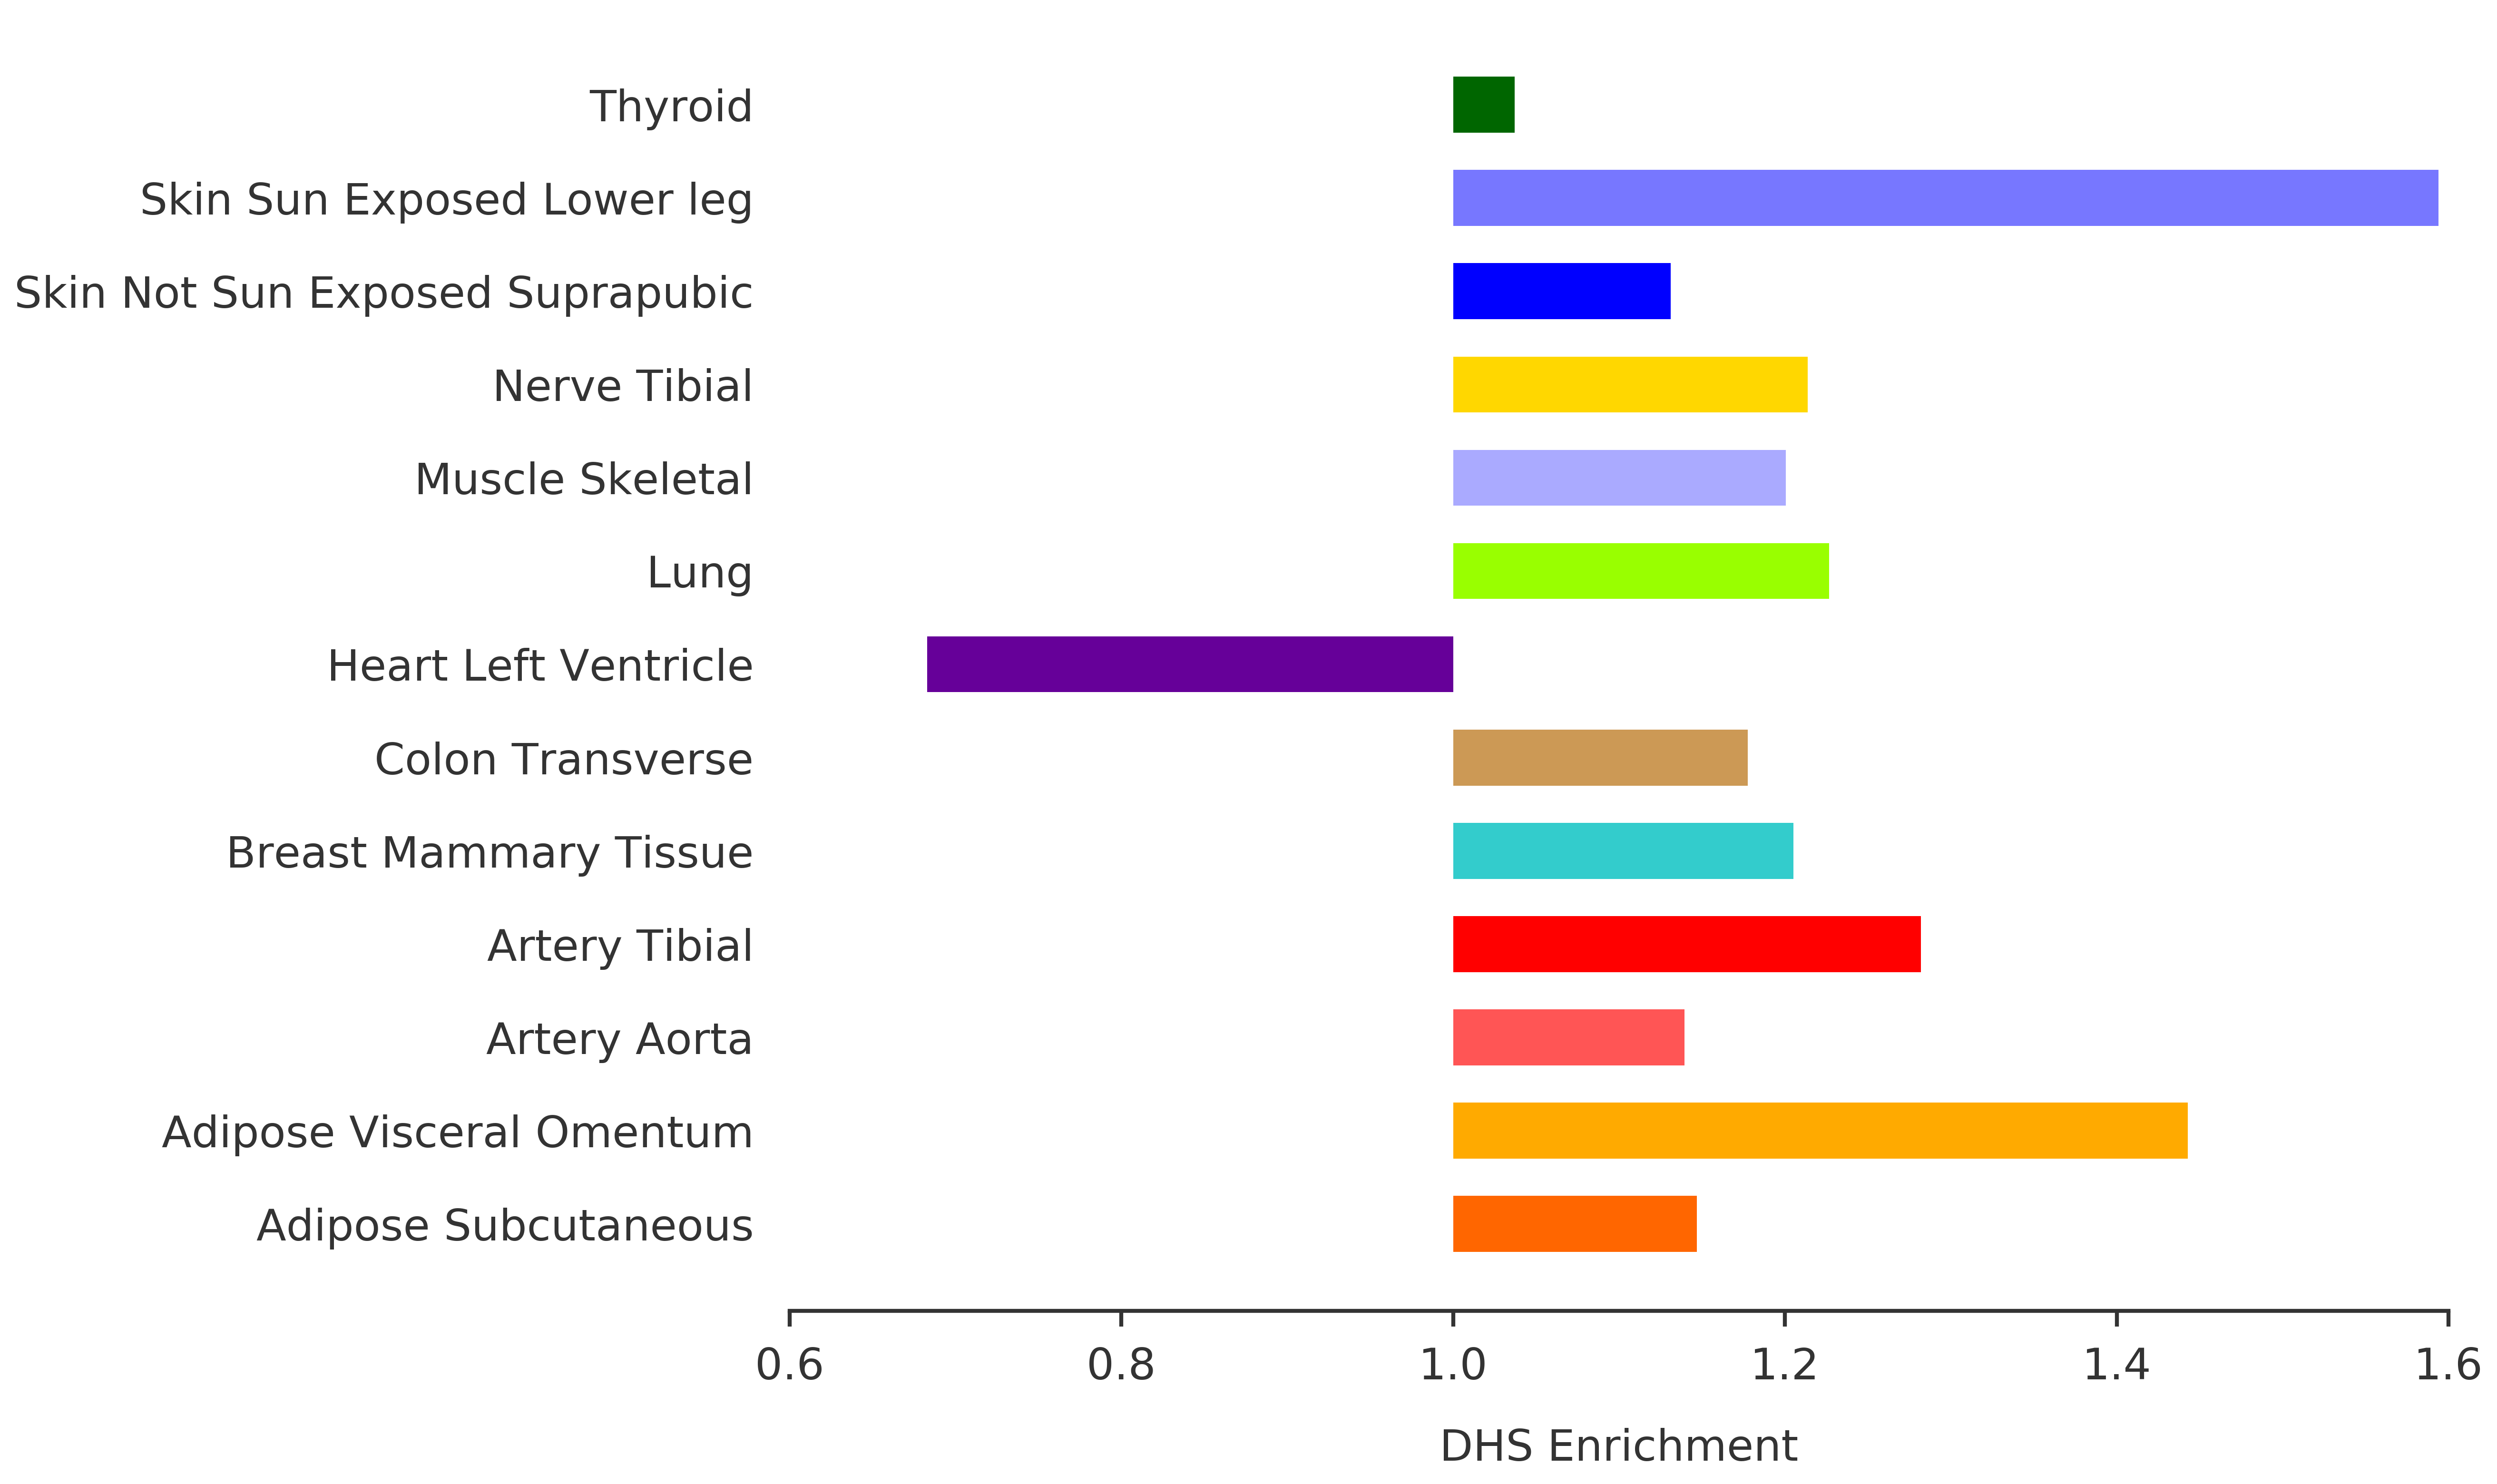

In [37]:
objects = list()
performance = list()
significance = list()
bar_colors = list()

for tshort in tshorts:
    if tshort in tissuelist:
        nteqtl = len(transeqtls[tshort])
        if nteqtl > 0:
            objects.append(tissue_names[tshort])
            performance.append(enrichment[tshort] - 1.0)
            significance.append('')
#             if tf_enrichment_pval <= 0.001:
#                 significance.append('***')
#             elif tf_enrichment_pval <= 0.01:
#                 significance.append('**')
#             elif tf_enrichment_pval <= 0.05:
#                 significance.append('*')
#             else:
#                 significance.append('')
            bar_colors.append(tissue_colors[tshort])
        

fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(111)

y_pos = np.arange(len(objects))
bar1 = ax1.barh(y_pos, performance, align='center', color = bar_colors, linewidth = 0, height = 0.6)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(objects)
ax1.set_xlabel('DHS Enrichment')
xmax = np.around(np.max(performance) + 0.05, decimals = 1)
xmin = np.around(np.min(performance) - 0.05, decimals = 1)
ax1.set_xlim([xmin, xmax])

ax1.tick_params(bottom = True, top = False, left = False, right = False, labelleft = True, labelbottom = True)
for side, border in ax1.spines.items():
    if not side == 'bottom':
        border.set_visible(False)
        
# Add p-values beside the bars
for i, rect in enumerate(bar1):
    width = rect.get_width()
    xpos = rect.get_width() + 0.02
    ypos = rect.get_y() + rect.get_height() / 2.0
    ax1.text(xpos, ypos, f'{significance[i]}', ha='left', va='center')

fig.canvas.draw()
xticklabels = [f'{x.get_position()[0] + 1 :3.1f}' for x in ax1.get_xticklabels()]
ax1.set_xticklabels(xticklabels)

outfile = "../plots/dhs_enrichment.png"
#plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')
plt.show()